# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
boston = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")

In [12]:
X = boston.iloc[:, :-1]
y = boston.iloc[:, -1]

In [13]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [49]:
def get_boostraped_sample(X, y, sample_size, replace=True):
    indices = np.random.choice(
        np.arange(X.shape[0]),
        size=sample_size,
        replace=replace
    )
    Xnew = X.iloc[indices]
    ynew = y.iloc[indices]
    out_of_bag = set(np.arange(X.shape[0])) - set(indices)
    return Xnew, ynew, indices, list(out_of_bag)

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    mask = np.zeros((X.shape[0], num_runs))
    oob_predictions = np.zeros_like(mask)
    for run in range(num_runs):
        Xnew, ynew, indices, out_of_bag = get_boostraped_sample(X, y, int(0.7 * len(X)))
        oob_X = X.iloc[out_of_bag]
        oob_y = y.iloc[out_of_bag]
        mask[out_of_bag, run] = 1
        regressor.fit(Xnew, ynew)
        pred = regressor.predict(oob_X)
        oob_predictions[out_of_bag, run] = pred
    mean_by_samples = oob_predictions.sum(axis=1) / mask.sum(axis=1)
    mean_by_samples = mean_by_samples.reshape(-1, 1)
    std_by_samples = ((oob_predictions - mean_by_samples)**2 * mask).sum(axis=1) / mask.sum(axis=1)

    bias = ((mean_by_samples - y.to_numpy().reshape(-1, 1))**2).mean()
    variance = std_by_samples.mean()
    error = ((oob_predictions - y.to_numpy().reshape(-1, 1))**2 * mask).sum() / mask.sum()

    return bias, variance, error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
names = ["Linear Regression", "Decision Tree", "Random Forest"]

for model, name in zip(models, names):
    bias, var, err = compute_biase_variance(model, X, y)
    print(f"{name}:")
    print(f"   {bias} + {var} = {err}")


Linear Regression:
   23.827222218999854 + 1.445627110300772 = 25.141439050633252
Decision Tree:
   10.828761760902028 + 14.40542841609498 = 25.152622635051774
Random Forest:
   11.459187000316374 + 2.6202387167886996 = 14.023020732437482


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
Согласуются. Как и обсуждалось на семинарах, bias у линейной модели очень высокий, зато низкий variance, что говорит о том, что модель не сильно переобучается, но слабо умеет обобщать свои предсказания. У дерева решений наоборот bias меньше, но высокий variance, что свидетельствует о переобучении дерева. В случае Random Forest bias получился не слишком высокий (сопоставимый с bias у дерева решений), а variance сильно упал. Это тоже соответствует теории - у нас деревья решений в случайном лесе строятся, чтобы уменьшить попарную корреляцию --> отсюда получается уменьшение variance

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [42]:
from sklearn.ensemble import BaggingRegressor

models = [
    BaggingRegressor(LinearRegression()),
    BaggingRegressor(DecisionTreeRegressor()),
    BaggingRegressor(RandomForestRegressor(n_estimators=30))]
names = ["Bagged Linear Regression", "Bagged Decision Tree", "Bagged Random Forest"]

for model, name in zip(models, names):
    bias, var, err = compute_biase_variance(model, X, y)
    print(f"{name}:")
    print(f"   {bias} + {var} = {err}")


Bagged Linear Regression:
   23.752241174589198 + 1.5520903316760661 = 25.394510237367797
Bagged Decision Tree:
   11.390220262226842 + 3.8870153787251205 = 15.230840597233962
Bagged Random Forest:
   12.653889403484962 + 1.6522790894352934 = 14.255725753848056


Для решающего дерева и Random Forest разброс действительно уменьшился (не в N раз, поскольку какая-то корреляция между моделями, используемыми в бэггинге все равно есть). Для линейной регрессии разброс не уменьшился, что говорит о сильной скоррелированности базовых моделей в ансамбле

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [71]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    X_test, y_test, _, oob = get_boostraped_sample(X, y, num_test_objects, replace=False)
    X_train = X.iloc[oob]
    y_train = y.iloc[oob]
    for run in range(num_runs):
        Xnew, ynew, _, _ = get_boostraped_sample(X_train, y_train, len(X_train))
        regressor.fit(Xnew, ynew)
        pred = regressor.predict(X_test)
        ax.scatter(
            np.arange(num_test_objects),
            pred,
            c="c",
            alpha=0.5
        )
    ax.scatter(
        np.arange(num_test_objects),
        y_test,
        c="black",
        s=50
    )
    ax.set_xlabel("test samples")
    ax.set_ylabel("predictions for test samples")
    ax.set_title(f"Predictions of {title}")

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

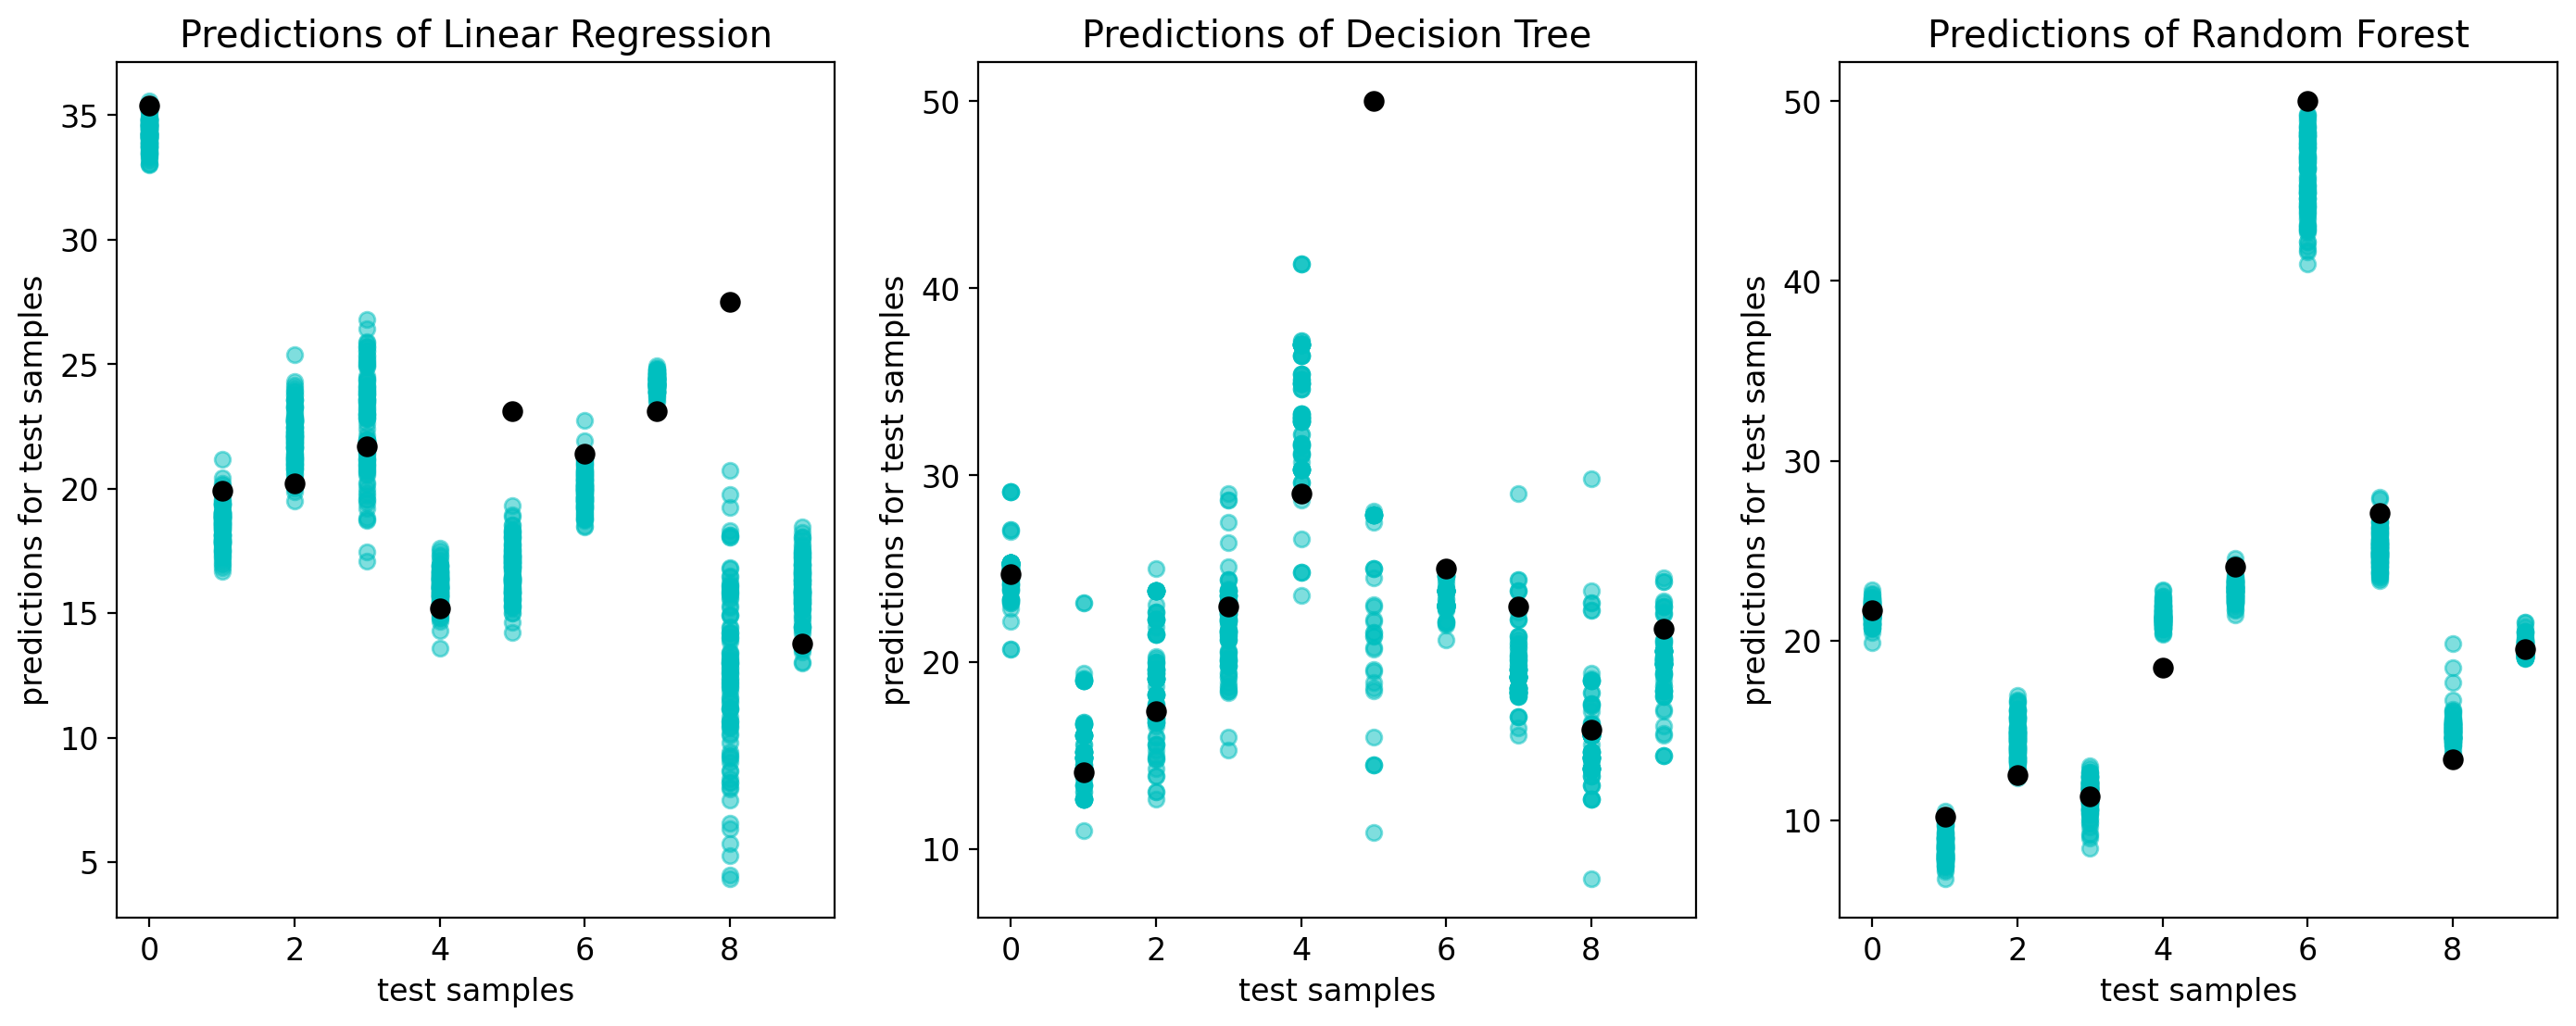

In [73]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
_, axes = plt.subplots(1, 3, figsize=(16, 4))

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
names = ["Linear Regression", "Decision Tree", "Random Forest"]

for m, ax, name in zip(models, axes, names):
    plot_predictions(m, X, y, title=name, ax=ax)

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__
1. Линейная регрессия. Черные точки (реальные ответы) расположены далеко от центра голубой полосы, которая характеризует предсказания алгоритмов. Это показывает, что смещение линейной модели высокое. В то же время ширина этих полос не слишком большая (на графике видно, что она как минимум меньше, чем разброс точек для решающего дерева), из этого следует, что разброс у линейной модели не велик.
2. Решающее дерево. черные точки почти по центру голубых полос, а значит у решающего дерева низкое смещение - предсказания в среднем дают что-то близкое к реальному ответу. В то же время разброс голубых точек велик, то есть variance у решающего дерева высокий.
3. Random Forest. Черные точки расположены не слишком далеко от голубых полос (ближе, чем для линейной регрессии) --> небольшое смещение. В то же время скученность голубых точек большая, что характеризует малый разброс модели случайного леса.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

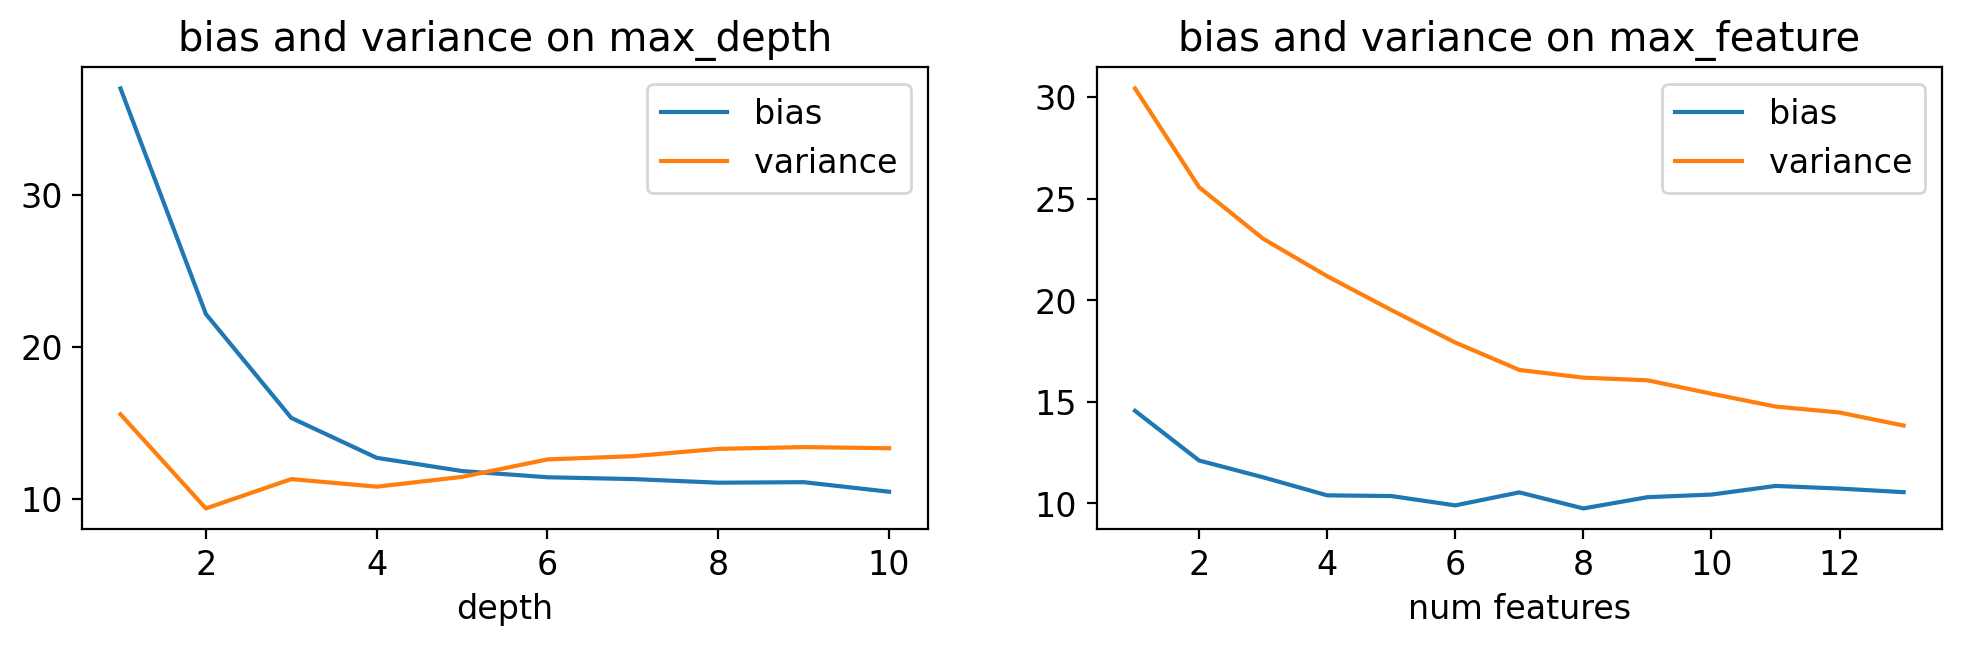

In [79]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))

max_depthes = np.arange(1, 11)
max_features = np.arange(1, X.shape[1] + 1)
biases = []
vars = []
for d in max_depthes:
    bias, var, _ = compute_biase_variance(
        DecisionTreeRegressor(max_depth=d),
        X, y, num_runs=200
    )
    biases.append(bias)
    vars.append(var)

ax[0].plot(max_depthes, biases, label="bias")
ax[0].plot(max_depthes, vars, label="variance")
ax[0].set_title("bias and variance on max_depth")
ax[0].set_xlabel("depth")
ax[0].legend()

biases = []
vars = []
for d in max_features:
    bias, var, _ = compute_biase_variance(
        DecisionTreeRegressor(max_features=d),
        X, y, num_runs=200
    )
    biases.append(bias)
    vars.append(var)

ax[1].plot(max_features, biases, label="bias")
ax[1].plot(max_features, vars, label="variance")
ax[1].set_title("bias and variance on max_feature")
ax[1].set_xlabel("num features")
ax[1].legend()


__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

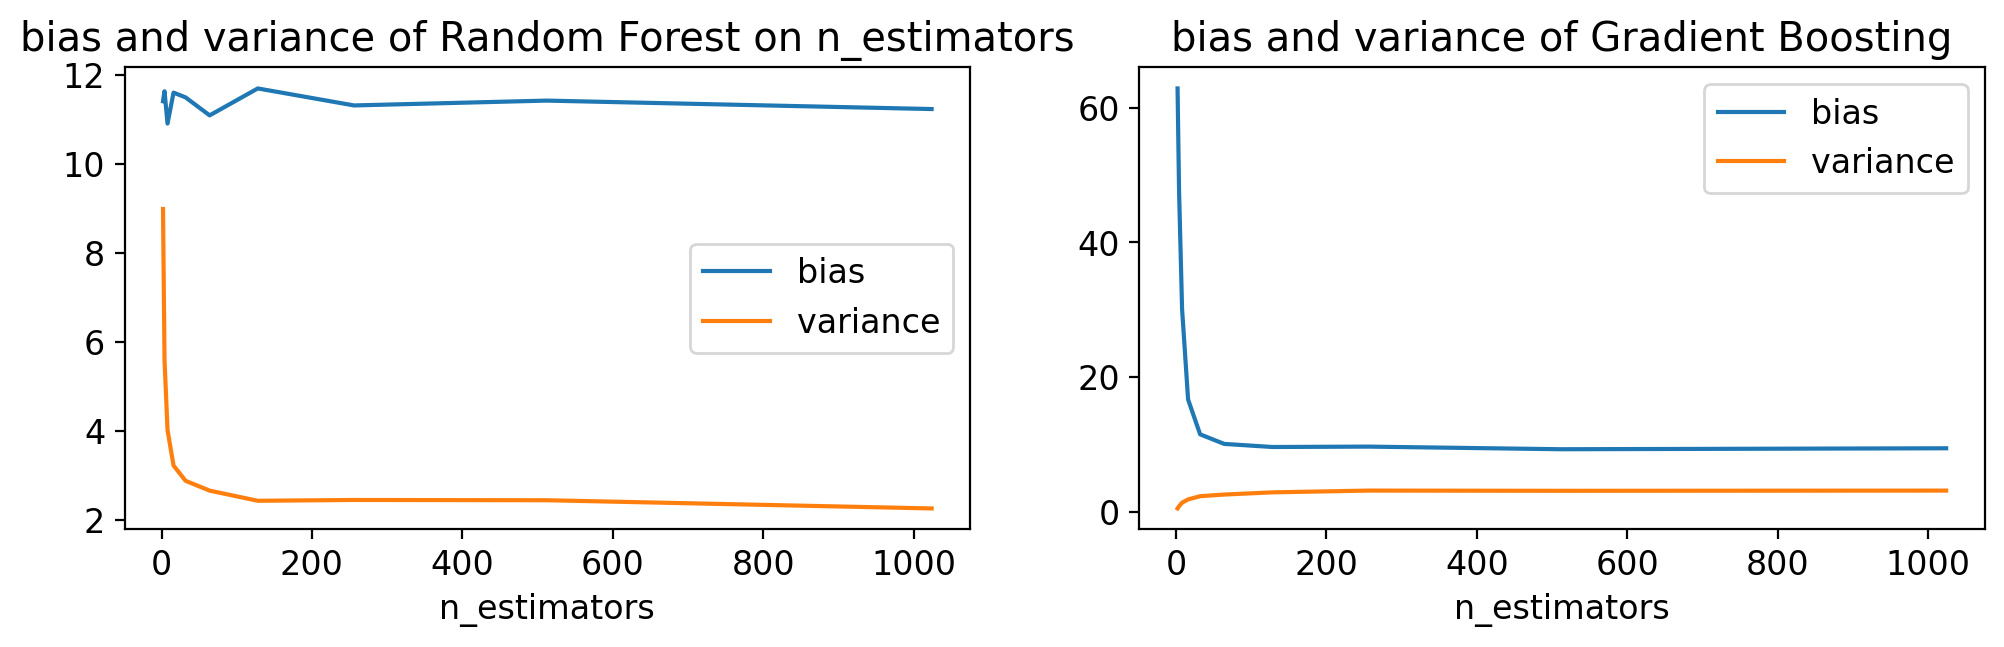

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators = 2**np.arange(1, 11)
biases_boosting = []
biases_forest = []
vars_boosting = []
vars_forest = []
for n in n_estimators:
    bias, var, _ = compute_biase_variance(
        RandomForestRegressor(n_estimators=n),
        X, y, num_runs=100
    )
    biases_forest.append(bias)
    vars_forest.append(var)
    bias, var, _ = compute_biase_variance(
        GradientBoostingRegressor(n_estimators=n),
        X, y, num_runs=100
    )
    biases_boosting.append(bias)
    vars_boosting.append(var)

_, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(n_estimators, biases_forest, label="bias")
ax[0].plot(n_estimators, vars_forest, label="variance")
ax[0].set_title("bias and variance of Random Forest")
ax[0].set_xlabel("n_estimators")
ax[0].legend()


ax[1].plot(n_estimators, biases_boosting, label="bias")
ax[1].plot(n_estimators, vars_boosting, label="variance")
ax[1].set_title("bias and variance of Gradient Boosting")
ax[1].set_xlabel("n_estimators")
ax[1].legend()


__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

#### max_depth и max_features
С ростом ```max_depth``` смещение дерева уменьшается, а разброс увеличивается, что соответсвует интуиции: модель становится более сложной, и вместе с тем более склонной к переобучению.

C ростом ```max_features``` разброс дерева убывает, а смещение сильно не меняется. У модели становится больше свободы в выборе фичей для сплита, а значит она начинает меньше переобучаться под особенности какой-то конкретной фичи, соответственно разброс уменьшается.

#### Random Forest и Gradient Boosting
С ростом числа деревьев смещение Random Forest продолжает оставаться примерно на одном уровне, а разброс сначала сильно убывает, а затем становится примерно постоянным для больших значений ```n_estimators```. Это соответствует теории - случайный лес устроен как бэггинг над слабо скоррелированными деревьями, а значит по формулам из лекции у нас разброс должен падать, а смещение остается равным смещению одной базовой модели.

С ростом числа деревьев смещение бустинга сильно уменьшается, а разброс растет, но в какой то момент обе величины остаются примерно постоянными. Бустинг с каждой новой моделью становится сложнее и способен сильнее обобщаться на тестовые данные, из за чего смещение и падает. Вместе с тем, бустинг подвержен переобучению в отличие от Random Forest-a, а значит его разброс растет по мере роста сложности (количества моделей в бустинге). Но в какой то момент, когда мы уже достаточно хорошо подстроились под данные, к полученной композиции начинают прибавляться модели, которые вносят слабые изменения в весь ансамбль (мы же обучаемся на сдвиги, а значит недалеко от оптимума эти сдвиги могут быть достаточно маленькими), то есть смещение и разброс перестают особо меняться, что соответсвует полученному графику.  

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__